### In this part, I will train a xgboost regression model to predict the y_test. Basically i have 2 plans:
1. Use the original revenue as label, and use the prediction directly
2. Use the corrected revenue as label, make the prediction, then convert it to the revenue in released date according to cpi

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cpi
from datetime import date
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE 
import xgboost as xgb

In [8]:
df = pd.read_csv('dataset/processed_data.csv')

In [9]:
print(df.shape)
df.head()

(7398, 128)


,id,has_collection,budget_ori,budget_corrected,num_genres,is_Science_Fiction,is_Drama,is_TV_Movie,is_Action,is_War,...,is_cast_Johnny_Depp,is_cast_Stanley_Tucci,is_cast_Harrison_Ford,is_cast_Richard_Jenkins,is_cast_Ben_Stiller,runtime,release_date,data,revenue_corrected,revenue
0,1,0,14000000,1.532722e+07,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,93.0,2015-02-20,train,1.348210e+07,12314651.0
1,2,0,40000000,5.424253e+07,4.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,113.0,2004-08-06,train,1.290287e+08,95149435.0
2,3,1,3300000,3.571594e+06,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,105.0,2014-10-10,train,1.416949e+07,13092000.0
3,4,1,1200000,1.344288e+06,2.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,122.0,2012-03-09,train,1.792383e+07,16000000.0
4,5,1,0,0.000000e+00,2.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,118.0,2009-02-05,train,4.752081e+06,3923970.0


In [10]:
df_train = df[df['data']=='train']
df_test = df[df['data']=='test']
print(df_train.shape)
print(df_test.shape)

(3000, 128)
(4398, 128)


In [11]:
train_x = df_train.drop(['id','data', 'release_date', 'revenue_corrected', 'revenue'], axis = 1)
train_y_ori = df_train[['revenue']]
train_y_cor = df_train[['revenue_corrected']]
test_x = df_test.drop(['id','data', 'release_date', 'revenue_corrected', 'revenue'], axis = 1)
test_y_ori = df_test[['revenue']]
test_y_cor = df_test[['revenue_corrected']]

release_date_test = list(df_test['release_date'])

### plan1

In [12]:
minus = []

# https://xgboost.readthedocs.io/en/latest/parameter.html
model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators = 100, eta=0.1, max_depth=4) 

# K-fold cross validation
kf = KFold(n_splits=4, shuffle=True, random_state=None)
for train_index, valid_index in kf.split(train_x):
    x_train, x_validation = train_x.loc[train_index, :], train_x.loc[valid_index, :]
    y_train, y_validation = np.array(train_y_cor.loc[train_index, :]), np.array(train_y_cor.loc[valid_index, :])
    # Fitting the model on x_train
    model.fit(x_train, y_train) 
    # Predict the model on validation
    pred = model.predict(x_validation) 
    
    for i,item in enumerate(pred):
        if pred[i]<=0:
            minus.append(y_validation[i][0])
            
    # RMSE Computation 
    rmse = np.sqrt(MSE(y_validation, pred)) 
    print("RMSE : % f" %(rmse))
    
# retrain the model with all training set:
model.fit(train_x, train_y_cor)

print('/n')
# feature importance
fea_importance = {}
importances = model.feature_importances_
for i, item in enumerate(list(train_x)):
    fea_importance[item] = importances[i]
fea_importance= sorted(fea_importance.items(), key=lambda x:x[1], reverse=True)
for item in fea_importance[:10]:
    print(item[0], item[1])

# prediction
pred = model.predict(test_x) 
for i in range(len(pred)):
    if pred[i] <=0:
        pred[i] = 100
        continue
    

RMSE :  109674663.149597
RMSE :  142992269.104085
RMSE :  125892666.612473
RMSE :  122707189.656413
/n
budget_corrected 0.19471517
has_collection 0.093375586
is_Adventure 0.058288533
has_homepage 0.04773304
popu 0.046967693
budget_ori 0.0302578
release_year 0.030141596
runtime 0.027730273
is_Fantasy 0.026291559
is_Animation 0.021498434


In [13]:
df_result = pd.DataFrame()
df_result['id'] = df_test['id']
df_result['revenue'] = pred
df_result.to_csv('dataset/submission_1209_1.csv', index=None)

### plan2

In [20]:
minus = []

# https://xgboost.readthedocs.io/en/latest/parameter.html
model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators = 100, eta=0.1, max_depth=4) 

# K-fold cross validation
kf = KFold(n_splits=4, shuffle=True, random_state=None)
for train_index, valid_index in kf.split(train_x):
    x_train, x_validation = train_x.loc[train_index, :], train_x.loc[valid_index, :]
    y_train, y_validation = np.array(train_y_cor.loc[train_index, :]), np.array(train_y_cor.loc[valid_index, :])
    # Fitting the model on x_train
    model.fit(x_train, y_train) 
    # Predict the model on validation
    pred = model.predict(x_validation) 
    
    for i,item in enumerate(pred):
        if pred[i]<=0:
            minus.append(y_validation[i][0])
            
    # RMSE Computation 
    rmse = np.sqrt(MSE(y_validation, pred)) 
    print("RMSE : % f" %(rmse))
    
# retrain the model with all training set:
model.fit(train_x, train_y_cor)

print('/n')
# feature importance
fea_importance = {}
importances = model.feature_importances_
for i, item in enumerate(list(train_x)):
    fea_importance[item] = importances[i]
fea_importance= sorted(fea_importance.items(), key=lambda x:x[1], reverse=True)
for item in fea_importance[:10]:
    print(item[0], item[1])

# prediction
pred = model.predict(test_x) 
print(len([item for item in pred if item <=0]))
for i in range(len(pred)):
    if pred[i] <=0:
        pred[i] = 100
        continue
    
    # cpi adjustment  
    try:
        y = int(release_date_test[i].split('-')[0])
        m = int(release_date_test[i].split('-')[1])
        d = int(release_date_test[i].split('-')[2])
    except:
        continue
    pred[i] = cpi.inflate(pred[i], date(2019,12,31), to=date(y,m,d))

RMSE :  134680198.370913
RMSE :  147056411.674309
RMSE :  119844917.213541
RMSE :  118146711.522776
/n
budget_corrected 0.19471517
has_collection 0.093375586
is_Adventure 0.058288533
has_homepage 0.04773304
popu 0.046967693
budget_ori 0.0302578
release_year 0.030141596
runtime 0.027730273
is_Fantasy 0.026291559
is_Animation 0.021498434
271


In [15]:
df_result = pd.DataFrame()
df_result['id'] = df_test['id']
df_result['revenue'] = pred
df_result.to_csv('dataset/submission_1209_2.csv', index=None)

### Evaluation & Conclusion

As you can see from above the RMSE from 4-fold cross validation is huge, and I'm not satisfied with it.
And I have some data where I got a negative number for the prediction, which is not possible, so after studing those samples, I replace them to a small fixed number. 

Anyway, I submit 3 results to the platform
For sample_submisstion, all samples are given a same prediction of 1000000, and I got a score of 3.79
Then I tried plan1, and I got a score of 3.19, much better, but still it ranks about 1000/1400
Then I tried plan2, and I got a score of 3.17, slightly better, but still it sucks

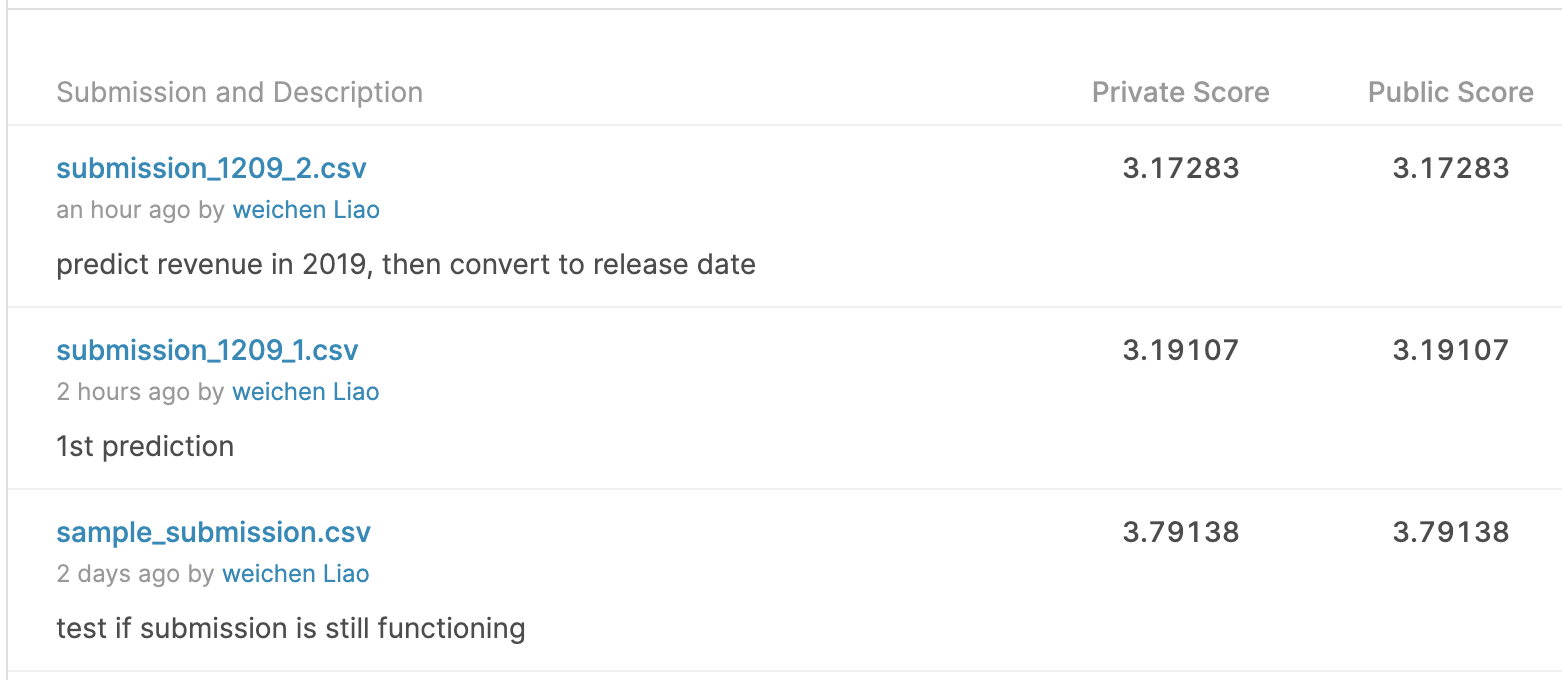

In [19]:
from IPython.display import Image
Image(filename = "pic_mo_1.png", width = 600, height = 300)

Although I have barely optimize the parameters, but I don't think there will be great improvements without enhancement of features. The way I see it, the main limitation of this project is as follows:
1. the size of traning set is too small. there 4000 plus samples to predict, but only 3000 samples to train, which is too few to train an effective label
2. the limitation of features. We lack some key features like the director and the number of movies competing at the same time(as less competition will lead to more revenues).

Futher more, there might be some critical issues as I come up with some negative predictions. Due to the time limit, I have to stop here submit my work.

So by this moment, I didn't spend more time to improve the parameters and I checked the discussions a little bit, and I realized most of the teams were using external datasets to improve the prediction such as additional trainning data and rot tomato scores, or even more, crawled revenues. The best score reached without external data seems to be 1.91, which is still far better than my result.
